# 目次

- データ確認
- 正規分布の確認
- 関係性の確認
- 正規分布の確認
- 反復特徴量選択方
- 特徴量重要度

# ライブラリ群

In [22]:
# データ処理
import csv
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.options.display.float_format = '{:.0f}'.format

# データ準備
from sklearn.model_selection import train_test_split # データ分割

# アルゴリズム
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
import xgboost as xgb # XGBoost
import lightgbm as lgb # LightGBM

# 評価
from sklearn.metrics import accuracy_score # 各評価指標
from sklearn import metrics

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP'] # 日本語対応
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [23]:
wine_red = pd.read_csv("./winequality-red.csv", sep=',')
wine_white = pd.read_csv("./winequality-white.csv", sep=',')

In [219]:
wine_red.shape
wine_red.head()

(1599, 12)

,固定酸度,揮発性酸性度,クエン酸,残留糖分,塩化物,遊離二酸化硫黄,総二酸化硫黄,密度,pH,硫酸塩,アルコール,品質
0,7,1,0,2,0,11,34,1,4,1,9,5
1,8,1,0,3,0,25,67,1,3,1,10,5
2,8,1,0,2,0,15,54,1,3,1,10,5
3,11,0,1,2,0,17,60,1,3,1,10,6
4,7,1,0,2,0,11,34,1,4,1,9,5


In [220]:
wine_white.shape
wine_white.head()

(4898, 12)

,固定酸度,揮発性酸性度,クエン酸,残留糖分,塩化物,遊離二酸化硫黄,総二酸化硫黄,密度,pH,硫酸塩,アルコール,品質
0,7,0,0,21,0,45,170,1,3,0,9,6
1,6,0,0,2,0,14,132,1,3,0,10,6
2,8,0,0,7,0,30,97,1,3,0,10,6
3,7,0,0,8,0,47,186,1,3,0,10,6
4,7,0,0,8,0,47,186,1,3,0,10,6


In [25]:
# レコード件数比較
def show_graph(labels, records, color, va):
    graph = plt.bar(labels, records, color=color)

    def autolabel(graph):
        for rect in graph:
            labels = rect.get_height()
            plt.annotate('{}'.format(labels),
                xy=(rect.get_x() + rect.get_width() / 2, labels),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va=va)

    plt.grid()
    autolabel(graph);

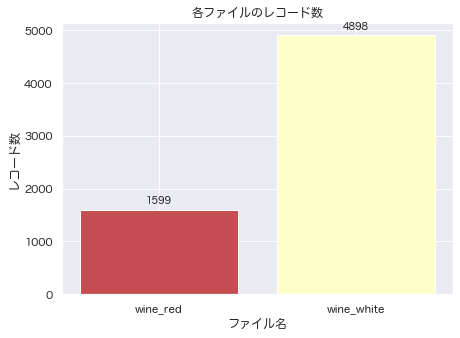

In [26]:
# レコード件数をプロット
x1=len(wine_red)
x2=len(wine_white)
records=[x1,x2]
labels=['wine_red','wine_white']
color=['r','#FFFFCC']
va='bottom'

plt.figure(figsize=[7,5])
plt.title('各ファイルのレコード数')
plt.xlabel('ファイル名')
plt.ylabel('レコード数')
show_graph(labels, records, color, va);

※以下、赤ワイン（wine_red）のデータを用いて解析する

In [27]:
wine_red['品質'].value_counts()
wine_white['品質'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: 品質, dtype: int64

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: 品質, dtype: int64

# 関係性の確認

## 散布図行列

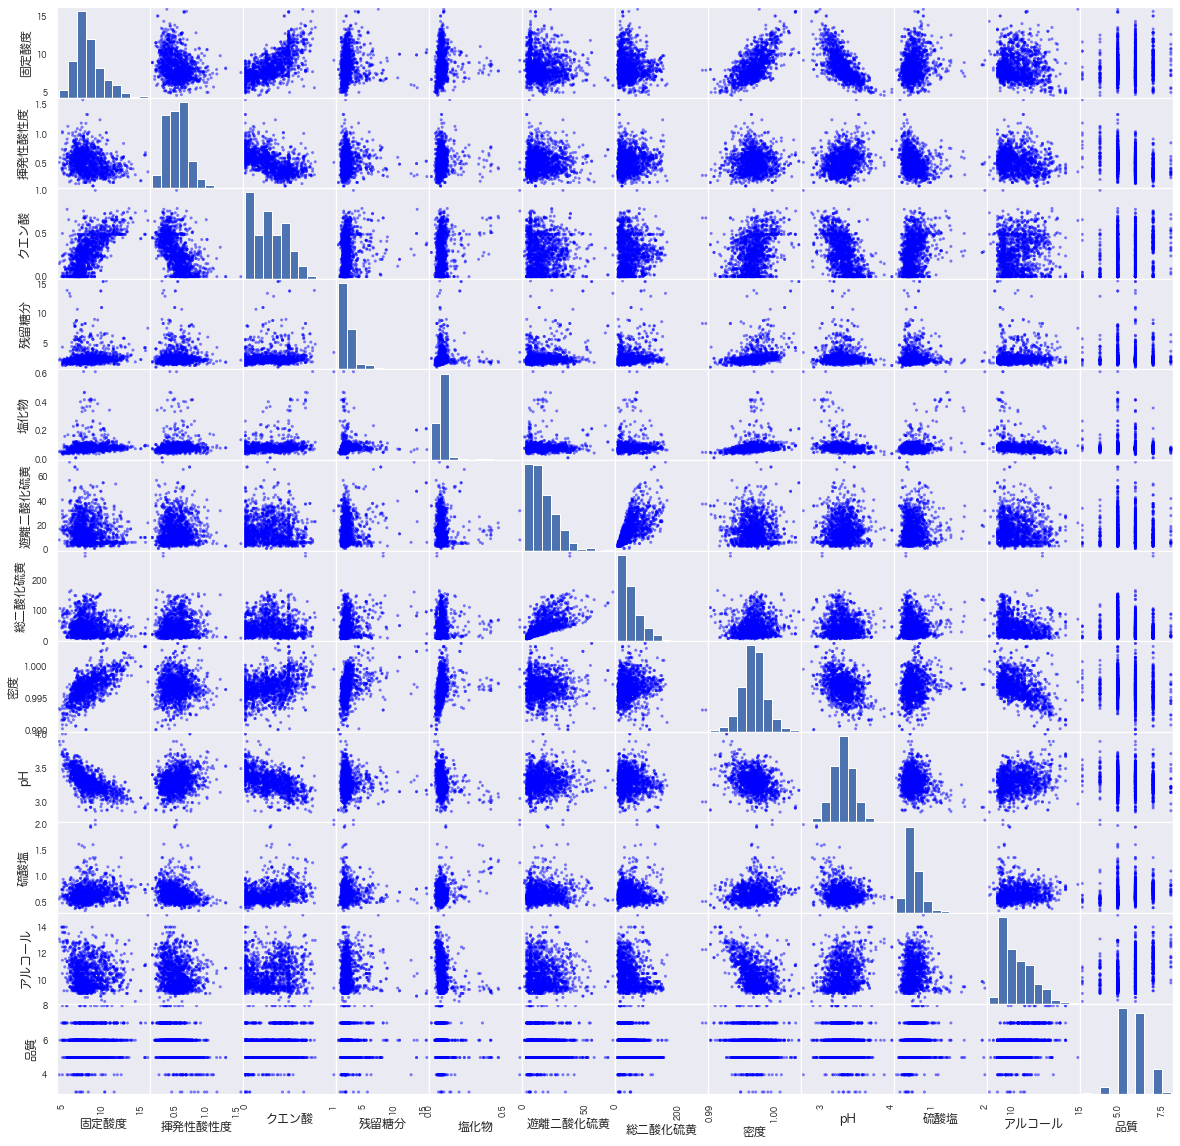

In [29]:
pd.plotting.scatter_matrix(wine_red, c='blue', figsize=(20, 20));

## ヒートマップ

In [182]:
def target_relation(tgt, data):
    y_train = data[tgt]

    # ヒートマップの表示数
    k = len(data.columns)
    fig = plt.figure(figsize=(20,20))

    # 各変数間の相関係数
    corrmat = data.corr()

    # リストの最大値から順にk個の要素を取得
    cols = corrmat.nlargest(k, tgt)[tgt].index

    # 全て可視化
    for i in np.arange(1, k):
        X_train = data[cols[i]]
        ax = fig.add_subplot(6,5, i)
        sns.regplot(x=X_train, y=y_train)
    
    plt.tight_layout()
    plt.show();

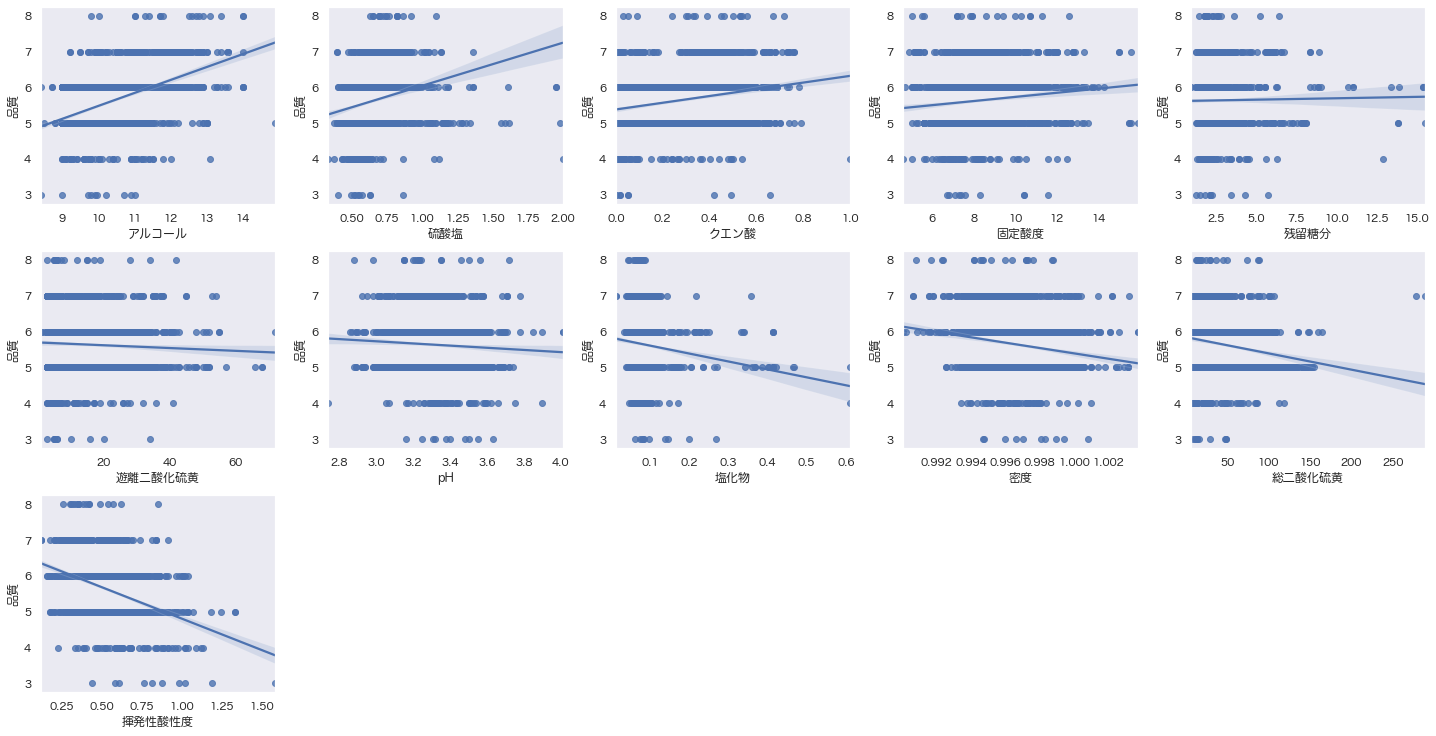

In [183]:
# 目的変数との関係性
target_relation(tgt='品質', data=wine_red)

## 相関係数

### ピアソンの積率相関係数

In [186]:
pearson=wine_red.corr(method='pearson') # 'pearson': ピアソンの積率相関係数（デフォルト）
pr_corr_df = pd.DataFrame()
pr_corr_df = pearson.round(decimals=3).astype(str)
pr_corr_df

,固定酸度,揮発性酸性度,クエン酸,残留糖分,塩化物,遊離二酸化硫黄,総二酸化硫黄,密度,pH,硫酸塩,アルコール,品質
固定酸度,1.0,-0.256,0.672,0.115,0.094,-0.154,-0.113,0.668,-0.683,0.183,-0.062,0.124
揮発性酸性度,-0.256,1.0,-0.552,0.002,0.061,-0.011,0.076,0.022,0.235,-0.261,-0.202,-0.391
クエン酸,0.672,-0.552,1.0,0.144,0.204,-0.061,0.036,0.365,-0.542,0.313,0.11,0.226
残留糖分,0.115,0.002,0.144,1.0,0.056,0.187,0.203,0.355,-0.086,0.006,0.042,0.014
塩化物,0.094,0.061,0.204,0.056,1.0,0.006,0.047,0.201,-0.265,0.371,-0.221,-0.129
遊離二酸化硫黄,-0.154,-0.011,-0.061,0.187,0.006,1.0,0.668,-0.022,0.07,0.052,-0.069,-0.051
総二酸化硫黄,-0.113,0.076,0.036,0.203,0.047,0.668,1.0,0.071,-0.066,0.043,-0.206,-0.185
密度,0.668,0.022,0.365,0.355,0.201,-0.022,0.071,1.0,-0.342,0.149,-0.496,-0.175
pH,-0.683,0.235,-0.542,-0.086,-0.265,0.07,-0.066,-0.342,1.0,-0.197,0.206,-0.058
硫酸塩,0.183,-0.261,0.313,0.006,0.371,0.052,0.043,0.149,-0.197,1.0,0.094,0.251


「pH⇆固定酸度」の相関係数が[-0.683]（負の相関）

In [187]:
# ピアソンの積率相関係数（自装してみた）
def pearson_corr(x, y):
    x_diff = x - np.mean(x)
    y_diff = y - np.mean(y)
    return np.dot(x_diff, y_diff) / (np.sqrt(sum(x_diff ** 2)) * np.sqrt(sum(y_diff ** 2)))

In [189]:
corr = pearson_corr(wine_red['pH'], wine_red['固定酸度'])
corr

-0.6829781945685298

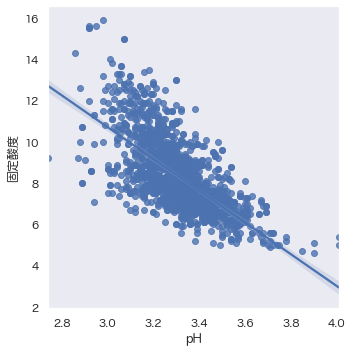

In [190]:
plt.figure(figsize=(5,5))
sns.regplot(x=wine_red['pH'], y=wine_red['固定酸度'])
plt.tight_layout()
plt.show();

### スピアマンの順位相関係数

In [193]:
spearman=wine_red.corr(method='spearman') # 'spearman': スピアマンの順位相関係数
sp_corr_df = pd.DataFrame()
sp_corr_df = spearman.round(decimals=3).astype(str)
sp_corr_df

,固定酸度,揮発性酸性度,クエン酸,残留糖分,塩化物,遊離二酸化硫黄,総二酸化硫黄,密度,pH,硫酸塩,アルコール,品質
固定酸度,1.0,-0.278,0.662,0.221,0.251,-0.175,-0.088,0.623,-0.707,0.213,-0.067,0.114
揮発性酸性度,-0.278,1.0,-0.61,0.032,0.159,0.021,0.094,0.025,0.234,-0.326,-0.225,-0.381
クエン酸,0.662,-0.61,1.0,0.176,0.113,-0.076,0.009,0.352,-0.548,0.331,0.096,0.213
残留糖分,0.221,0.032,0.176,1.0,0.213,0.075,0.145,0.422,-0.09,0.038,0.117,0.032
塩化物,0.251,0.159,0.113,0.213,1.0,0.001,0.13,0.411,-0.234,0.021,-0.285,-0.19
遊離二酸化硫黄,-0.175,0.021,-0.076,0.075,0.001,1.0,0.79,-0.041,0.116,0.046,-0.081,-0.057
総二酸化硫黄,-0.088,0.094,0.009,0.145,0.13,0.79,1.0,0.129,-0.01,-0.001,-0.258,-0.197
密度,0.623,0.025,0.352,0.422,0.411,-0.041,0.129,1.0,-0.312,0.161,-0.462,-0.177
pH,-0.707,0.234,-0.548,-0.09,-0.234,0.116,-0.01,-0.312,1.0,-0.08,0.18,-0.044
硫酸塩,0.213,-0.326,0.331,0.038,0.021,0.046,-0.001,0.161,-0.08,1.0,0.207,0.377


「遊離二酸化硫黄⇆総二酸化硫黄」の相関係数が[0.668→0.79]に上がっている。可視化して確認してみる。

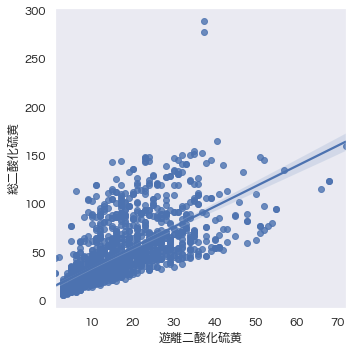

In [195]:
plt.figure(figsize=(5,5))
sns.regplot(x=wine_red['遊離二酸化硫黄'], y=wine_red['総二酸化硫黄'])
plt.tight_layout()
plt.show();

確かに相関性はありそうである。外れ値を除けば相関係数の変化がありそう。

# 正規分布の確認

## ヒストグラム

### pH

In [30]:
# 平均と分散
ph_mean = np.mean(wine_red['pH'])
ph_mean
ph_var = np.var(wine_red['pH'])
ph_var
import math
ph_std = math.sqrt(ph_var)
ph_std
ph_std2 = np.std(wine_red['pH'])
ph_std2

3.311113195747343

0.023820274241131745

0.15433818141060152

0.15433818141060152

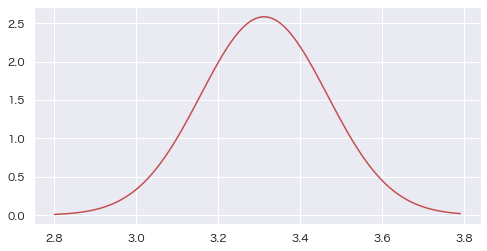

In [31]:
from scipy.stats import norm

# 2.8から3.8まで、0.01間隔のリストXを生成
X = np.arange(2.8,3.8,0.01)

# 確率密度関数Xに、平均=ph_mean、標準偏差=ph_stdを代入
Y = norm.pdf(X, ph_mean, ph_std)

# 正規分布を生成
plt.figure(figsize=[8,4])
plt.plot(X,Y,color='r')
plt.grid()
plt.show();

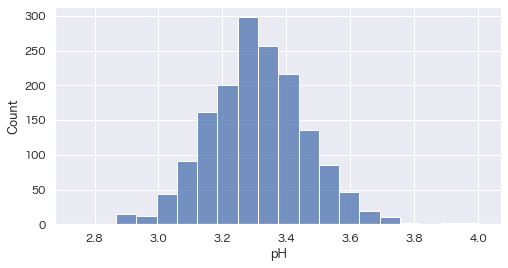

In [32]:
plt.figure(figsize=[8,4])
plt.grid()
sns.histplot(wine_red['pH'], bins=20);

### 密度

In [33]:
# 平均と分散
dens_mean = np.mean(wine_red['密度'])
dens_mean
dens_var = np.var(wine_red['密度'])
dens_var
dens_std = math.sqrt(dens_var)
dens_std

0.9967466791744833

3.5598017926307117e-06

0.0018867437008323923

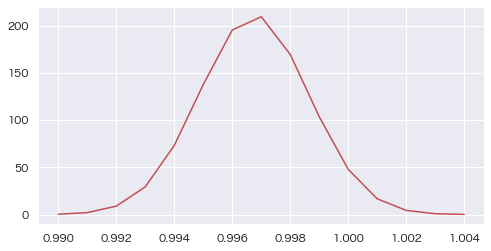

In [34]:
# 0.99から1.004まで、0.001間隔のリストXを生成
X = np.arange(0.99,1.004, 0.001)

# 確率密度関数Xに、平均=dens_mean、標準偏差=dens_stdを代入
Y = norm.pdf(X, dens_mean, dens_std)

plt.figure(figsize=[8,4])
plt.plot(X,Y,color='r')
plt.grid()
plt.show();

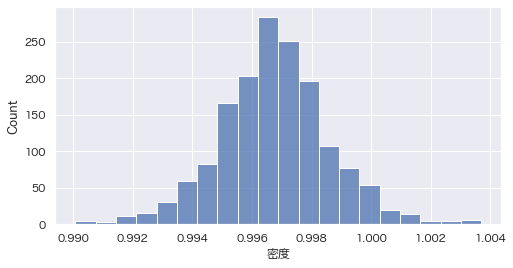

In [35]:
plt.figure(figsize=[8,4])
plt.grid()
sns.histplot(wine_red['密度'], bins=20);

## QQプロット

In [36]:
import scipy.stats as stats

def qqplot(dist):
    plt.figure(figsize=[8,4])
    plt.hist(dist, bins=30)
    plt.grid()
    plt.show()
    
    plt.figure(figsize=[8,4])
    stats.probplot(dist, dist="norm", plot=plt)
    plt.grid()
    plt.show()

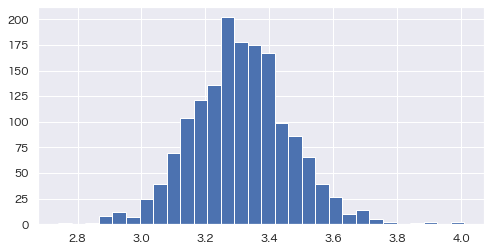

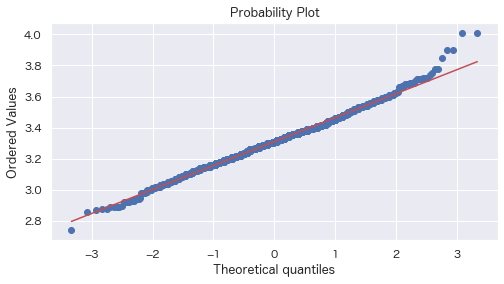

In [37]:
qqplot(wine_red['pH'])

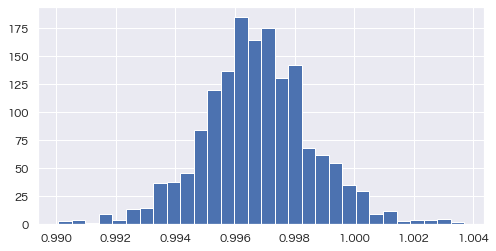

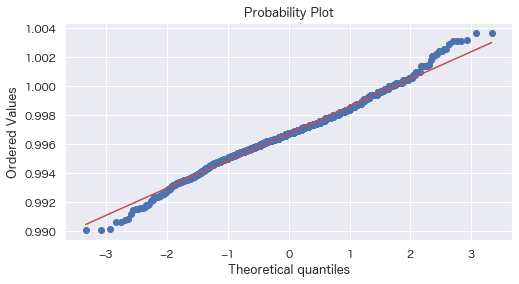

In [38]:
qqplot(wine_red['密度'])

累積分布の25%点と75%点の直線上に、おおよそ分布しており、正規分布に近いと思われる。

##  母相関係数の無相関検定

In [216]:
from scipy.stats import pearsonr, spearmanr

# pH と 密度について無相関検定を実施する
ph = wine_red['pH'].values
density = wine_red['密度'].values

# ピアソンの相関係数とp値を計算する。
result = pearsonr(ph, density)
# 結果
r_value = result[0]
p_value = result[1]
print('相関係数：', r_value)
print('p値：', p_value)

print('='*30)

# スピアマンの相関係数とp値を計算する場合
result2 = spearmanr(ph, density)
# 結果
r_value2 = result2[0]
p_value2 = result2[1]
print('相関係数：', r_value2)
print('p値：', p_value2)

相関係数： -0.34169933478503145
p値： 5.117102011974621e-45
相関係数： -0.31205507820838724
p値： 1.882938603579213e-37


どちらも、p値 < 有意水準（0.05）であるため帰無仮説は棄却され、二つの変数は無相関ではないだろう（相関があるだろう）と考えられる。

# 反復特徴量選択法

## 変数減少法（後方削除法）

In [49]:
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.preprocessing import normalize

X = wine_red.drop(columns='品質', axis=1)
y = wine_red['品質']

X_norm = normalize(X, norm='l2')
rfe = RFE(estimator=linear_model.LinearRegression(), n_features_to_select=5)
rfe.fit(X_norm, y)
rfe_features = pd.DataFrame(X_norm, columns=wine_red.columns[:-1]).loc[:, rfe.get_support()].columns.tolist()

print(f'重要度が上位5件の特徴量： {rfe_features}')

RFE(estimator=LinearRegression(), n_features_to_select=5)

重要度が上位5件の特徴量： ['pH' '塩化物' '密度' '揮発性酸性度' '硫酸塩']


上位5件を残し、他の特徴量を削除

# 特徴量重要度

## 回帰

### Lasso回帰

スコア： 0.666
選択項目数： 7、除外項目数： 4


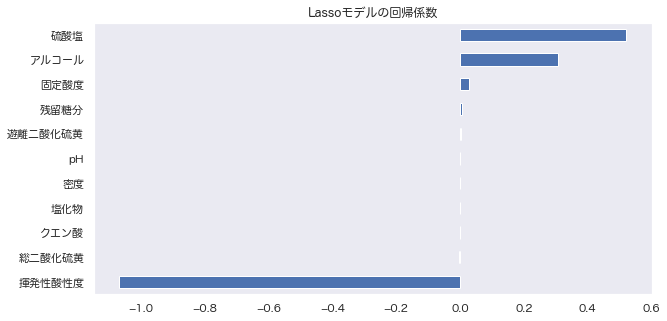

In [177]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

X = wine_red.drop(columns='品質', axis=1)
y = wine_red['品質']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# model_ridge = Ridge().fit(X_train, y_train)
model_lasso = LassoCV().fit(X_train, y_train)
print(f'スコア： {rmse_cv(model_lasso).mean().round(decimals=3)}')

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("選択項目数： " + str(sum(coef != 0)) + "、除外項目数： " +  str(sum(coef == 0)))
  
plt.figure(figsize=[10,5])
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Lassoモデルの回帰係数");

### ロジスティック回帰

In [178]:
# ロジスティック回帰
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LogisticRegression

# データ分割
X = wine_red.drop(columns='品質', axis=1)
y = wine_red['品質']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# パイプライン化
pipe_lr = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000, C=5.0))
pipe_lr.fit(X_train, y_train)

# 予測、評価
y_pred = pipe_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'正解率： {accuracy}')
print("="*20)

# 回帰係数
print("回帰係数")
for col in np.argsort(pipe_lr.steps[1][1].coef_[0])[::-1]:
    print("{0}: {1}".format(X.columns[col], pipe_lr.steps[1][1].coef_[0][col].round(decimals=3)));

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=5.0, max_iter=1000))])

正解率： 0.6375
回帰係数
揮発性酸性度: 5.018
塩化物: 1.994
pH: 1.2
密度: 1.014
残留糖分: 0.58
固定酸度: 0.18
遊離二酸化硫黄: -0.464
硫酸塩: -0.878
アルコール: -1.278
総二酸化硫黄: -1.409
クエン酸: -1.954


選択項目数： 11、除外項目数： 0


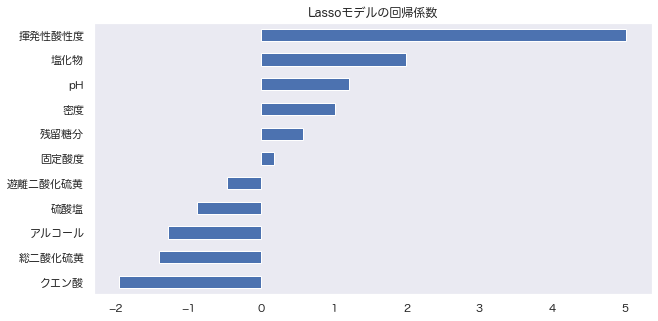

In [179]:
# 回帰係数
coef = pd.Series(pipe_lr.steps[1][1].coef_[0], index = X_train.columns)
imp_coef = coef.sort_values()
print("選択項目数： " + str(sum(coef != 0)) + "、除外項目数： " +  str(sum(coef == 0)))

# 可視化
plt.figure(figsize=[10,5])
imp_coef.plot(kind = "barh")
plt.title("Lassoモデルの回帰係数");

## ランダム・フォレスト

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# データ分割
X = wine_red.drop(columns='品質', axis=1)
y = wine_red['品質']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# モデリング
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

# 評価
accu = accuracy_score(y_test, y_pred)
print('accuracy = {:>.4f}'.format(accu))

# 重要度
fimp = clf_rf.feature_importances_

# データフレームに変換
imp_df = pd.DataFrame()
imp_df['項目名'] = wine_red.columns[:-1]
imp_df['重要度'] = fimp.round(decimals=4).astype(str)
imp_df.sort_values(by='重要度', ascending=False)

RandomForestClassifier()

accuracy = 0.7344


,項目名,重要度
10,アルコール,0.1487
9,硫酸塩,0.1125
1,揮発性酸性度,0.1027
6,総二酸化硫黄,0.0996
7,密度,0.0906
4,塩化物,0.079
3,残留糖分,0.0776
2,クエン酸,0.0749
8,pH,0.0743
0,固定酸度,0.0738


全体的に重要度が高くない。

### 上位3項目で再確認

In [223]:
# データ分割
target_feature = ['アルコール', '硫酸塩', '揮発性酸性度']
X = wine_red[target_feature]
y = wine_red['品質']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# モデリング
clf_rf2 = RandomForestClassifier()
clf_rf2.fit(X_train, y_train)
y_pred2 = clf_rf2.predict(X_test)

# 評価
accu2 = accuracy_score(y_test, y_pred2)
print('accuracy = {:>.4f}'.format(accu2))

# 重要度
fimp2 = clf_rf2.feature_importances_

# データフレームに変換
imp_df = pd.DataFrame()
imp_df['項目名'] = target_feature
imp_df['重要度'] = fimp2.round(decimals=4).astype(str)
imp_df.sort_values(by='重要度', ascending=False)

RandomForestClassifier()

accuracy = 0.6687


,項目名,重要度
2,揮発性酸性度,0.3526
0,アルコール,0.3392
1,硫酸塩,0.3082


重要度が上昇。本来なら要考察。

In [ ]:
# 決定木を可視化する
from dtreeviz.trees import dtreeviz

estimators = clf_rf2.estimators_
viz = dtreeviz(
    estimators[1], X, y,
    feature_names=wine_red['アルコール'],
    class_names=list(wine_red['品質']),
) 
display(viz)
plt.savefig('trees.png')

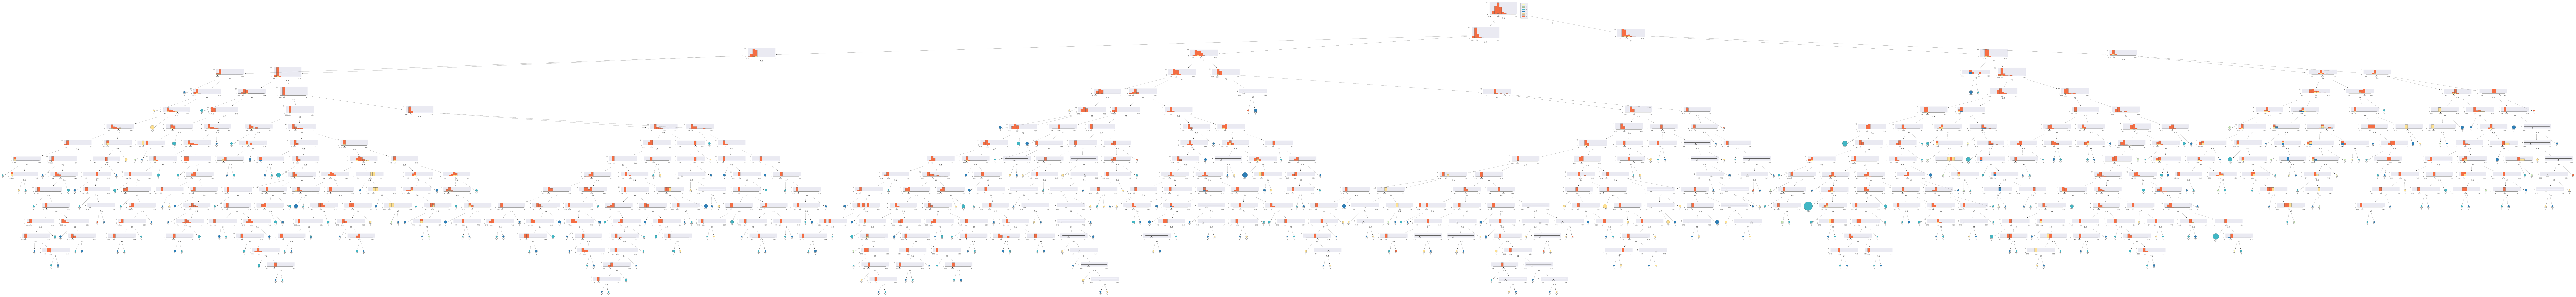

In [221]:
from IPython.display import Image
Image("./trees.png")

## 勾配ブースティング

### XGBoost

[12:54:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:54:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

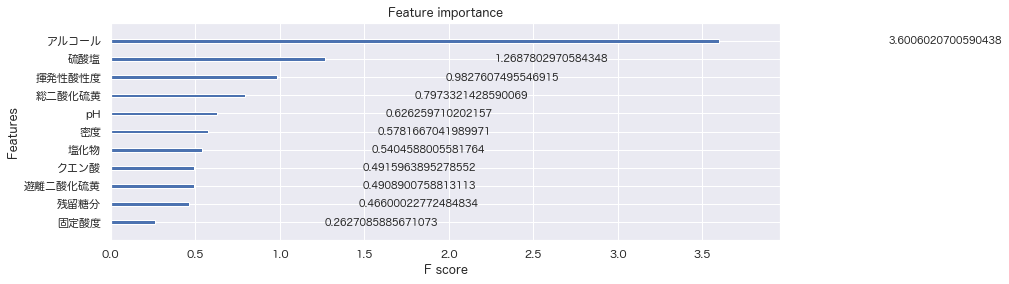

In [71]:
# XGBoost
import xgboost as xgb

# データ分割
X = wine_red.drop(columns='品質', axis=1)
y = wine_red['品質']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# パラメータ
xgb_params = {"objective": "reg:linear", "eta": 0.1, "max_depth": 6, "silent": 1}
num_rounds = 100

# XGBoost用のデータセットの作成
dtrain = xgb.DMatrix(X_train, label=y_train)

# 学習
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

# 重要度
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(gbdt, ax=ax, importance_type='gain') # gain: 予測精度をどれだけ改善させたることができるできたか（平均値）

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

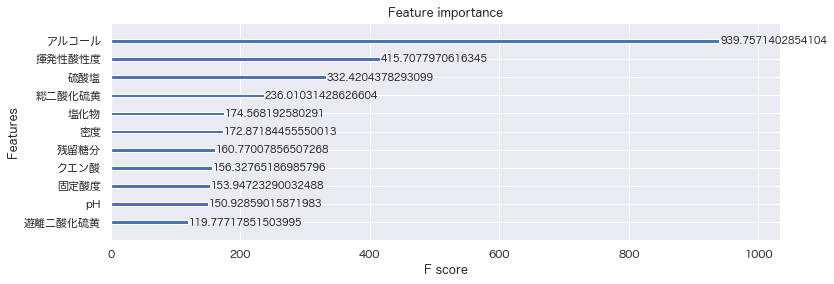

In [77]:
# gainの合計値
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(gbdt, ax=ax, importance_type='total_gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

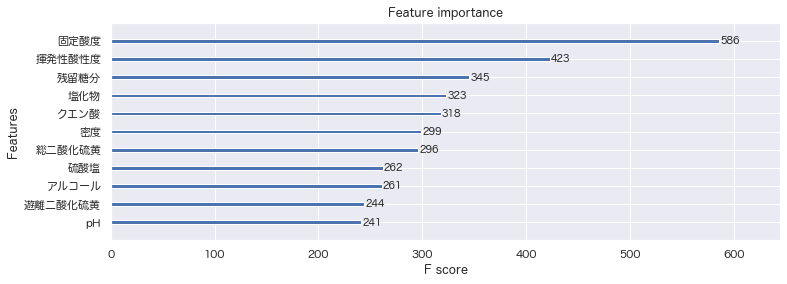

In [70]:
# 生成された全ての木の中にその変数がいくつ分岐として存在するか（平均値）
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(gbdt, ax=ax, importance_type='weight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

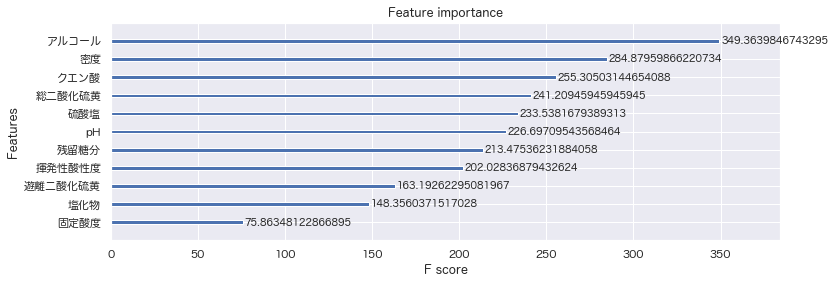

In [74]:
# 一つの入力が何度この変数によって分岐されたか
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(gbdt, ax=ax, importance_type='cover')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

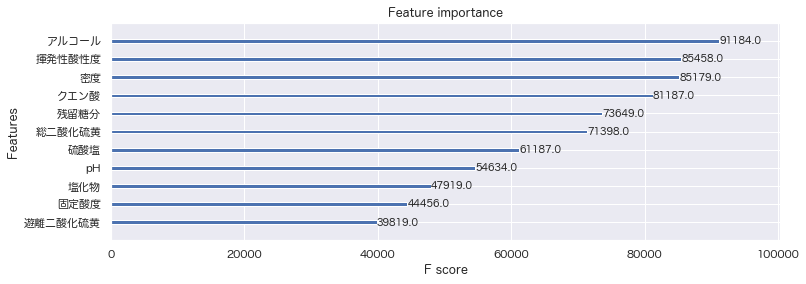

In [76]:
# coverの合計値
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(gbdt, ax=ax, importance_type='total_cover')

### LightGBM

In [106]:
#　LightGBM
import lightgbm as lgb

def lightgbm_learning(imp_type):
    # データ分割
    X = wine_red.drop(columns='品質', axis=1)
    y = wine_red['品質']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # パラメータ
    lgb_params = {"objective": "regression", "eta": 0.1, "max_depth": 6, "importance_type": imp_type}
    num_rounds = 100

    # LightGBM用のデータセットの作成
    dtrain = lgb.Dataset(X_train, label=y_train)

    # 学習
    lgbdt = lgb.train(lgb_params, dtrain, num_rounds)
    
    return lgbdt

# 重要度の可視化
def plot_feature_importance(df):
    n_features = len(df)
    df_plot = df.sort_values('重要度')
    f_importance_plot = df_plot['重要度'].values
    plt.figure(figsize=[10,4])
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['項目'].values
    plt.yticks(np.arange(n_features), cols_plot)
    plt.xlabel('特徴量重要度')
    plt.ylabel('項目')

In [110]:
# 学習
lgbdt = lightgbm_learning(imp_type='split')

# 特徴量重要度の算出
cols = list(wine_red.drop('品質',axis=1).columns)
f_importance = np.array(lgbdt.feature_importance())
df_importance = pd.DataFrame({'項目':cols, '重要度':f_importance})
df_importance = df_importance.sort_values('重要度', ascending=False)
display(df_importance)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 11
[LightGBM] [Info] Start training from score 5.646599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,項目,重要度
1,揮発性酸性度,185
4,塩化物,183
6,総二酸化硫黄,177
7,密度,174
10,アルコール,163
2,クエン酸,152
9,硫酸塩,140
3,残留糖分,137
8,pH,126
0,固定酸度,123


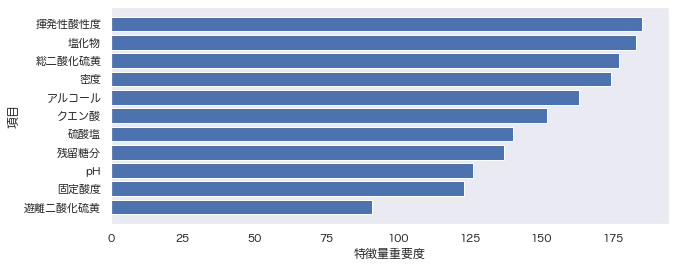

In [111]:
# 重要度の可視化
plot_feature_importance(df_importance)

In [113]:
# 学習
lgbdt = lightgbm_learning(imp_type='gain')

# 特徴量重要度の算出
cols = list(wine_red.drop('品質',axis=1).columns)
f_importance = np.array(lgbdt.feature_importance())
df_importance = pd.DataFrame({'項目':cols, '重要度':f_importance})
df_importance = df_importance.sort_values('重要度', ascending=False)
display(df_importance)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 11
[LightGBM] [Info] Start training from score 5.646599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,項目,重要度
1,揮発性酸性度,185
4,塩化物,183
6,総二酸化硫黄,177
7,密度,174
10,アルコール,163
2,クエン酸,152
9,硫酸塩,140
3,残留糖分,137
8,pH,126
0,固定酸度,123


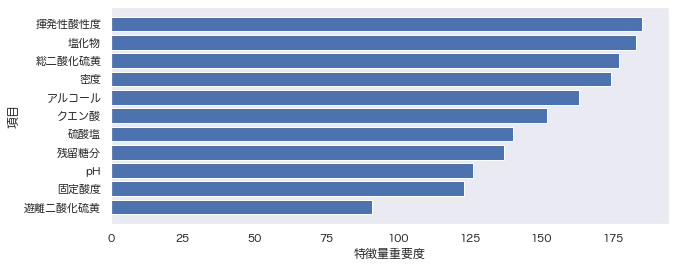

In [114]:
# 重要度の可視化
plot_feature_importance(df_importance)